# Dataset Version 1

This notebook generates a dataframe containing information about data first version dataset:

- Overlap of AbDb data (filtered and enriched abag data) with SAbDab data (affinity values for conformtions) 

In [1]:
import os
import pandas as pd
import warnings
from tqdm import tqdm_notebook

warnings.filterwarnings("ignore")
from abag_affinity.utils.config import read_config, get_data_paths, get_resources_paths

In [2]:
config = read_config("../../config.yaml")

summary_path, pdb_path = get_resources_paths(config, "SAbDab")
sabdb_summary_df = pd.read_csv(summary_path, sep="\t")
sabdb_summary_df = sabdb_summary_df.set_index("pdb")

abdb_summary_path, abdb_pdb_path = get_resources_paths(config, "AbDb")
abdb_summary_df = pd.read_csv(abdb_summary_path)
abdb_summary_df = abdb_summary_df.set_index("pdb")
abdb_pdb_ids = os.listdir(abdb_pdb_path)
abdb_pdb_ids = set([ pdb_id.split("_")[0].lower() for pdb_id in abdb_pdb_ids])

In [3]:
# get overlap using pdb ids
sabdab_pdb_ids = set(sabdb_summary_df.index.unique())
overlapping_ids = abdb_pdb_ids.intersection(sabdab_pdb_ids)

#### Incorporate redundant files

In [4]:
# load information on redundant AbDb files
redunant_file_path = os.path.join(config["RESOURCES"]["path"], config["RESOURCES"]["AbDb"]["folder_path"], "Redundant_LH_Protein_Martin.txt")
with open(redunant_file_path) as f:
    lines = f.readlines()
    
redundant_ids = {}
all_ids = set() # all (redundant) PDB ids in AbDb
for line in lines:
    pdb_ids = line.split(",")
    pdb_ids = [pdb_id.strip().lower().split("_")[0] for pdb_id in pdb_ids]
    pdb_ids = [pdb_id for pdb_id in pdb_ids if pdb_id.strip() != ""]
    all_ids.update(pdb_ids)
    for i, pdb_id in enumerate(pdb_ids):
        redundant_ids[pdb_id] = pdb_ids

In [5]:
# remove all PDB ids that are redundant to one of the overlapping PDB Ids
for pdb_id in overlapping_ids:
    for redundant_id in redundant_ids[pdb_id]:
        all_ids.discard(redundant_id)

In [6]:
add_pdbs = set()

remaining_in_sabdab = all_ids.intersection(sabdab_pdb_ids)
while len(remaining_in_sabdab) > 0:
    pdb_id = remaining_in_sabdab.pop()
    add_pdbs.add(pdb_id)
    for redundant_id in redundant_ids[pdb_id]:
        remaining_in_sabdab.discard(redundant_id)

In [7]:
# download extra pdb files from AbDb database
import urllib.request 

download_extra_files = False

if download_extra_files:

    url = "http://www.abybank.org/abdb/Data/LH_Protein_Martin/{}_1.pdb"

    for pdb_id in add_pdbs:
        pdb_id = pdb_id.upper()
        filepath = os.path.join(abdb_pdb_path, pdb_id + "_1.pdb")
        if os.path.exists(filepath):
            print(pdb, "already exists")
            continue
        try:
            urllib.request.urlretrieve(url.format(pdb_id), filepath)
        except:
            print(pdb_id)
        print("Downloaded", pdb_id)

In [8]:
#overlapping_ids.update(add_pdbs)

In [9]:
dataset = sabdb_summary_df[sabdb_summary_df.index.isin(overlapping_ids)].copy()
dataset = dataset.join(abdb_summary_df)

dataset = dataset[["affinity", "delta_g", "affinity_method", "temperature", 'abdb_filename', 'antibody_chains', 'antigen_chains', "Hchain", "Lchain", "antigen_chain"]]

In [10]:
dataset = dataset.drop_duplicates().reset_index()

In [11]:
import math
def get_chains(row):
    pdb_id = row["pdb"]
    pdb_id_rows = dataset[dataset["pdb"] == pdb_id]
    
    antibody_chains = []
    antigen_chains = []
    
    for i, pdb_row in pdb_id_rows.iterrows():
        antibody_chains.append(pdb_row["Hchain"])
        antibody_chains.append(pdb_row["Lchain"])
        
        if isinstance(pdb_row["antigen_chain"], str):
            if "|" in pdb_row["antigen_chain"]:
                for chain_id in pdb_row["antigen_chain"].split("|"):
                    antigen_chains.append(chain_id.strip())

            else:
                antigen_chains.append(pdb_row["antigen_chain"])
    
    return antibody_chains, antigen_chains

In [12]:
dataset["sabdab_antibody_chains"], dataset["sabdab_antigen_chains"] = zip(*dataset.apply(lambda row: get_chains(row), axis=1))

In [13]:
import numpy as np
gas_constant =  8.31446261815324 # 0.0821

def calc_temp(row):
    kd = row["affinity"]
    delta_g = row["delta_g"] * 4184 # convert kcal to joule 
    if kd == 0 or math.isnan(kd) or math.isnan(delta_g):
        return None

    return round((delta_g / (gas_constant * np.log(kd))) - 273.15) # convert kelvin to celsius

def calc_delta_g(row):
    delta_g = gas_constant * row["temperature_kelvin"] * np.log(row["affinity"])
    return delta_g / 4184 # convert to kcal

In [14]:
dataset["calculated_temp"] = dataset.apply(lambda row: calc_temp(row), axis=1)
dataset = dataset[~dataset["calculated_temp"].isnull()]

In [15]:
# calc -log(Kd)

dataset["-log(Kd)"] = dataset.apply(lambda row: -np.log10(row["affinity"]), axis=1)

dataset = dataset[dataset["-log(Kd)"].notnull()]

In [16]:
# add pdb file name from AbDb

abdb_pdb_path = os.path.join(config["RESOURCES"]["path"], config["RESOURCES"]["AbDb"]["folder_path"], config["RESOURCES"]["AbDb"]["pdb_path"])

pdb_files = os.listdir(abdb_pdb_path)

id2file = {file.split("_")[0].lower(): file for file in pdb_files}

In [17]:
#dataset["abdb_file"] = dataset["pdb"].apply(lambda pdb_id: id2file[pdb_id])
dataset["filename"] = dataset["abdb_filename"].fillna(dataset["pdb"].apply(lambda pdb_id: id2file[pdb_id]))

dataset = dataset[dataset["pdb"].isin(id2file.keys())]

dataset["filename"] = dataset["filename"].apply(lambda x: x.split(".")[0].upper() + "." + x.split(".")[1])

In [18]:
# clean dataset
dataset.drop_duplicates("pdb", inplace=True)
dataset = dataset.reset_index().drop("index", axis=1)
#dataset = dataset[["pdb", "abdb_file", "antigen_type", "antibody_chains", "antigen_chains", 'affinity_method', 'temperature', "calculated_temp", 'affinity', 'delta_g', '-log(Kd)' ]]

### Mark testset and delete redundant files

Use Antibody Benchmark as the final testset --> Remove redundant files.

In [19]:
dataset["test"] = False

In [20]:
benchmark_summary_path, benchmark_pdb_path = get_resources_paths(config, "AntibodyBenchmark")
benchmark_summary_df = pd.read_excel(benchmark_summary_path)
benchmark_summary_df = benchmark_summary_df.replace(" ", None)
benchmark_summary_df = benchmark_summary_df[benchmark_summary_df["ΔG (kcal/mol)"].notnull() & benchmark_summary_df["Kd (nM)"].notnull()]
benchmark_summary_df.reset_index(inplace=True)
benchmark_summary_df.drop("index", axis=1)
print("Numer of available benchmark structures >>>", len(benchmark_summary_df))

Numer of available benchmark structures >>> 53


In [21]:
benchmark_pdb_ids = set([ pdb_id.split("_")[0].lower() for pdb_id in benchmark_summary_df["Complex PDB"].unique() ])
overlapping_ids = benchmark_pdb_ids.intersection(set(dataset["pdb"].unique()))
print("Number of identical PDB of dataset and benchmark_pdb_ids", len(overlapping_ids))

Number of identical PDB of dataset and benchmark_pdb_ids 24


In [22]:
# Set these strucutres as testset strucutres in the dataset
dataset["test"] = dataset["pdb"].apply(lambda pdb_id: pdb_id in benchmark_pdb_ids)

In [23]:
benchmark_summary_df["pdb"] = benchmark_summary_df["Complex PDB"].apply(lambda pdb_id: pdb_id.split("_")[0].lower() )
remaining_benchmark = benchmark_summary_df[~benchmark_summary_df["pdb"].isin(overlapping_ids)].copy()
print("Remaining Benchmark Entries", len(remaining_benchmark))

Remaining Benchmark Entries 29


In [24]:
benchmark_pdb_ids = set(remaining_benchmark["pdb"].unique())
overlapping_ids = benchmark_pdb_ids.intersection(all_ids)
print("Number of found PDB benchmark_pdb_ids in redundant list >>>", len(overlapping_ids))
print("Number of found pdb_ids in that are also in dataset v1 >>>", len(overlapping_ids.intersection(set(dataset["pdb"].unique()))))
print("Number of found pdb_ids in that are also in SAbDab >>>", len(overlapping_ids.intersection(sabdab_pdb_ids)))
print("Number of found pdb_ids in that are also in AbDb >>>", len(overlapping_ids.intersection(abdb_pdb_ids)))
print("Number of found pdb_ids in that are also in AbDb and SAbDab >>>", len(overlapping_ids.intersection(abdb_pdb_ids).intersection(sabdab_pdb_ids)))
print("Number of found pdb_ids in neither in AbDb and SAbDab >>>", len(overlapping_ids - overlapping_ids.intersection(abdb_pdb_ids).union(overlapping_ids.intersection((sabdab_pdb_ids)))))

Number of found PDB benchmark_pdb_ids in redundant list >>> 12
Number of found pdb_ids in that are also in dataset v1 >>> 0
Number of found pdb_ids in that are also in SAbDab >>> 0
Number of found pdb_ids in that are also in AbDb >>> 10
Number of found pdb_ids in that are also in AbDb and SAbDab >>> 0
Number of found pdb_ids in neither in AbDb and SAbDab >>> 2


#### Add additional strucutures from AbDb
Add the 10 Strucutures that are also present in AbDb and use the affinity value of the benchmark dataset

In [25]:
from abag_affinity.utils.pdb_reader import read_file

ii = 0
for i, row in remaining_benchmark[remaining_benchmark["pdb"].isin(overlapping_ids.intersection(abdb_pdb_ids))].iterrows():
    ii += 1
    file_path = os.path.join(abdb_pdb_path, id2file[row["pdb"]])
    structure, _ = read_file(row["pdb"], file_path)
    chains = structure.get_chains()
    chains = set([ chain.id for chain in chains ])
    no_ab_chain = list(chains - set(["H", "L"]))
    
    
    new_entry = {
        "pdb": row["pdb"],
        "filename": id2file[row["pdb"]],
        "antigen_type": "protein",
        "antibody_chains": ["L", "H"],
        "antigen_chains": no_ab_chain,
        "affinity_method": "-",
        "temperature": np.nan,
        "calculated_temp": calc_temp({"affinity": row["Kd (nM)"] * 1e-9, "delta_g": row["ΔG (kcal/mol)"]}),
        "affinity": row["Kd (nM)"] * 1e-9,
        "delta_g":  row["ΔG (kcal/mol)"],
        "test": True
    }
    dataset = dataset.append(new_entry, ignore_index=True)
    
print(ii, "Rows added")

10 Rows added


#### Find data that is in SAbDab and Benchmark but not in dataset_v1

In [26]:
benchmark_pdb_ids = set([ pdb_id.split("_")[0].lower() for pdb_id in benchmark_summary_df["Complex PDB"].unique() ])
missing = benchmark_pdb_ids - set(dataset["pdb"].unique())

missing_but_sabdab = missing.intersection(sabdab_pdb_ids)
missing_but_sabdab

{'3rvw', '4gxu', '4pou', '5grj', '5hgg', '5kov', '5sv3'}

In [27]:
missing_sabdab_and_redundant = missing_but_sabdab.intersection(all_ids)
missing_sabdab_and_redundant

set()

Seems like there are 6 cases that are not present in the overlap between AbDb and SAbDab but have affinity values in the benchmark dataset.

In [28]:
benchmark_pdb_ids = set([ pdb_id.split("_")[0].lower() for pdb_id in benchmark_summary_df["Complex PDB"].unique() ])
overlapping_ids = benchmark_pdb_ids.intersection(set(dataset["pdb"].unique()))
print("There are still {} cases not in dataset_v1".format(len(benchmark_summary_df) - len(overlapping_ids)))

There are still 19 cases not in dataset_v1


In [29]:
remaining_benchmark = remaining_benchmark[~remaining_benchmark["pdb"].isin(overlapping_ids)]
print("Remaining Benchmark Entries", len(remaining_benchmark.isin(overlapping_ids)))

Remaining Benchmark Entries 19


In [30]:
print("There are in total {} complexes in the testset that are taken from the benchmark dataset".format(dataset["test"].sum()))

There are in total 34 complexes in the testset that are taken from the benchmark dataset


### Validation Splits

Split the train data randomly in 3 parts that can each be used for validation during model training and for hyperparameter tuning.

In [31]:
dataset["validation"] = 0
dataset = dataset.sort_values(by="test")
dataset.reset_index(inplace=True)

In [32]:
total_train_data = len(dataset[dataset["test"] == False])
print("There are in total {} complexes in available for training".format(total_train_data))

There are in total 357 complexes in available for training


In [33]:
np.random.seed(123)
indices = np.arange(total_train_data)
np.random.shuffle(indices)
val_indices = np.split(indices, [124, 248])

In [34]:
for i, val_idx in enumerate(val_indices):
    i += 1
    dataset.loc[val_idx, "validation"] = i

In [35]:
dataset.head()

,index,pdb,affinity,delta_g,affinity_method,temperature,abdb_filename,antibody_chains,antigen_chains,Hchain,Lchain,antigen_chain,sabdab_antibody_chains,sabdab_antigen_chains,calculated_temp,-log(Kd),filename,test,antigen_type,validation
0,0,1bj1,3.400000e-09,-11.550000,SPR,25,1BJ1_1.pdb,"['L', 'H']",['W'],H,L,W,"[H, L, K, J]","[W, V]",25.0,8.468521,1BJ1_1.pdb,False,NaN,1
1,257,5dd0,8.370000e-08,-9.655130,Unknown,NaN,5DD0_1.pdb,"['L', 'H']",['P'],H,L,P,"[H, L]",[P],25.0,7.077275,5DD0_1.pdb,False,NaN,3
2,256,5d8j,1.780000e-09,-11.936563,SPR,NaN,5D8J_1.pdb,"['L', 'H']",['A'],H,L,A,"[H, L]",[A],25.0,8.749580,5D8J_1.pdb,False,NaN,3
3,255,5d72,6.000000e-12,-15.309341,Unknown,NaN,5D72_1.pdb,"['L', 'H']","['B', 'A']",M,N,B,"[M, N, H, L]","[B, A]",25.0,11.221849,5D72_1.pdb,False,NaN,3
4,254,5czx,6.000000e-10,-12.580853,SPR,NaN,5CZX_1.pdb,"['L', 'H']",['A'],H,L,A,"[H, L, C, D]","[A, B]",25.0,9.221849,5CZX_1.pdb,False,NaN,2


In [36]:
# add chain infos column to resemble other datasets
from ast import literal_eval

def get_chain_infos(row):
    info = {}
    
    ab_chains = row["antibody_chains"]
    #if isinstance(row["antibody_chains"], float):
    #    ab_chains = row["sabdab_antibody_chains"]
    #else:
    #    ab_chains = row["antibody_chains"]
    if isinstance(ab_chains, str):
        ab_chains = literal_eval(ab_chains)
    else:
        ab_chains = []
    for chain in ab_chains:
        info[chain.lower()] = 0
    
    ag_chains = row["antigen_chains"]
    #if isinstance(row["antigen_chains"], float):
    #    ag_chains = row["sabdab_antigen_chains"]
    #else:
    #    ag_chains = row["antigen_chains"]    
    if isinstance(ag_chains, str):
        ag_chains = literal_eval(ag_chains)
    else:
        ag_chains = []
    for chain in ag_chains:
        info[chain.lower()] = 1
    return info

dataset["chain_infos"] = dataset.apply(get_chain_infos, axis=1)
dataset = dataset[dataset["chain_infos"] != {}]

In [37]:
dataset["data_location"] = "RESOURCES"

out_df = dataset[['pdb', 'data_location', 'filename', '-log(Kd)', "delta_g", "chain_infos", "validation", "test"]]
out_df = out_df.set_index("pdb", drop=False)
out_df.index.name = ""

In [38]:
# remove 6bli because antibody and antigen contain L chain --> Problem with model
out_df = out_df.drop("6bli")

In [39]:
out_df.to_csv(os.path.join(config["DATA"]["path"], config["DATA"]["Dataset_v1"]["folder_path"], config["DATA"]["Dataset_v1"]["summary"]))

### Delta G analysis

In [40]:
dataset["delta_g"].describe()

count    380.000000
mean     -11.490560
std        2.002948
min      -16.913816
25%      -12.758034
50%      -11.442210
75%      -10.243615
max       -5.178507
Name: delta_g, dtype: float64

<AxesSubplot:>

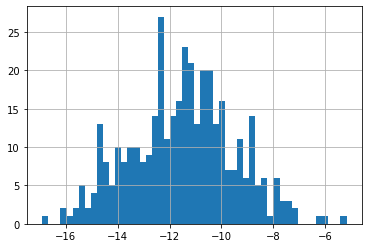

In [41]:
dataset["delta_g"].hist(bins=50)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>]], dtype=object)

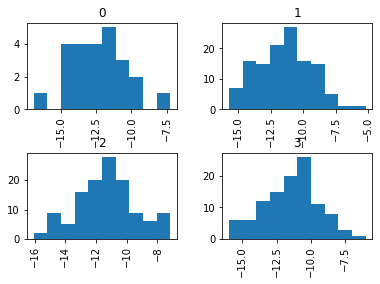

In [42]:
dataset["delta_g"].hist(bins=10,by=dataset["validation"])

In [43]:
dataset["affinity"].describe()

count    3.800000e+02
mean     7.520152e-07
std      8.551151e-06
min      4.000000e-13
25%      4.275000e-10
50%      4.250000e-09
75%      3.100000e-08
max      1.600000e-04
Name: affinity, dtype: float64

<AxesSubplot:>

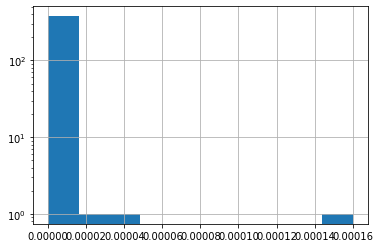

In [44]:
import matplotlib.pyplot as plt
plt.yscale("log")
dataset["affinity"].hist(bins=10)

## -log(Kg) Analyis

In [45]:
dataset["-log(Kd)"].describe()

count    380.000000
mean       8.418163
std        1.468840
min        3.795880
25%        7.508638
50%        8.371882
75%        9.369086
max       12.397940
Name: -log(Kd), dtype: float64

<AxesSubplot:>

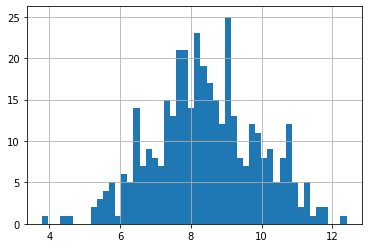

In [46]:
dataset["-log(Kd)"].hist(bins=50)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>]], dtype=object)

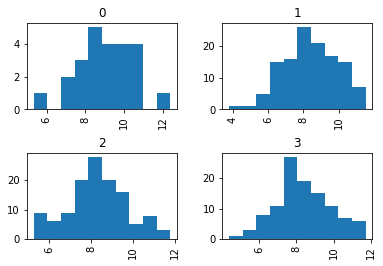

In [47]:
dataset["-log(Kd)"].hist(bins=10,by=dataset["validation"])

In [48]:
#dataset['antibody_chains'] = dataset['antibody_chains'].fillna(dataset['sabdab_antibody_chains'])
#dataset['antigen_chains'] = dataset['antigen_chains'].fillna(dataset['sabdab_antigen_chains'])

In [49]:
dataset['antigen_chains'][0]

"['W']"